<h1><b>GSK NLP Analyst Technical Case Study</b><h1>

<h3>Christine C. Amuzie<h3>
Broader Impact Data Services

<i>Completed: 2021.12.10</i>

<i>Last Modified: 2021.12.10</i>

Select a drug from the dataset. Imagine that a leader for that product has asked you the following question: “What aspects do patients like about using our product, and what do people dislike?”
Use the data to write a report for this leader that will address their question.

In [50]:
#!/Users/christineamuzie/opt/anaconda3/envs/p37env/bin/python
python /Users/christineamuzie/Documents/GitHub/Technical/GSK/analysis_1.0.ipynb
cp analysis_1.0.ipynb analysis_1.0
chmod +x analysis_1.0
./analysis_1.0



SyntaxError: invalid syntax (<ipython-input-50-112dcd6be540>, line 2)

In [47]:

import sys
print(sys.executable)
from subprocess import call
call("/Users/christineamuzie/opt/anaconda3/envs/p37env/bin/python /Users/christineamuzie/Documents/GitHub/Technical/GSK/analysis_1.0.ipynb", shell=True)


/Users/christineamuzie/opt/anaconda3/bin/python


1

In [48]:
# Checking versions
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

# Loading relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Setting visualization parameters 
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#Setting pytorch parameters
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

numpy       : 1.19.2
pandas      : 1.2.2
torch       : 1.10.0
transformers: 4.13.0



ModuleNotFoundError: No module named 'tensorflow'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   uniqueID  1957 non-null   int64 
 1   drugName  1957 non-null   object
 2   review    1957 non-null   object
 3   date      1957 non-null   object
dtypes: int64(1), object(3)
memory usage: 61.3+ KB


/Users/christineamuzie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


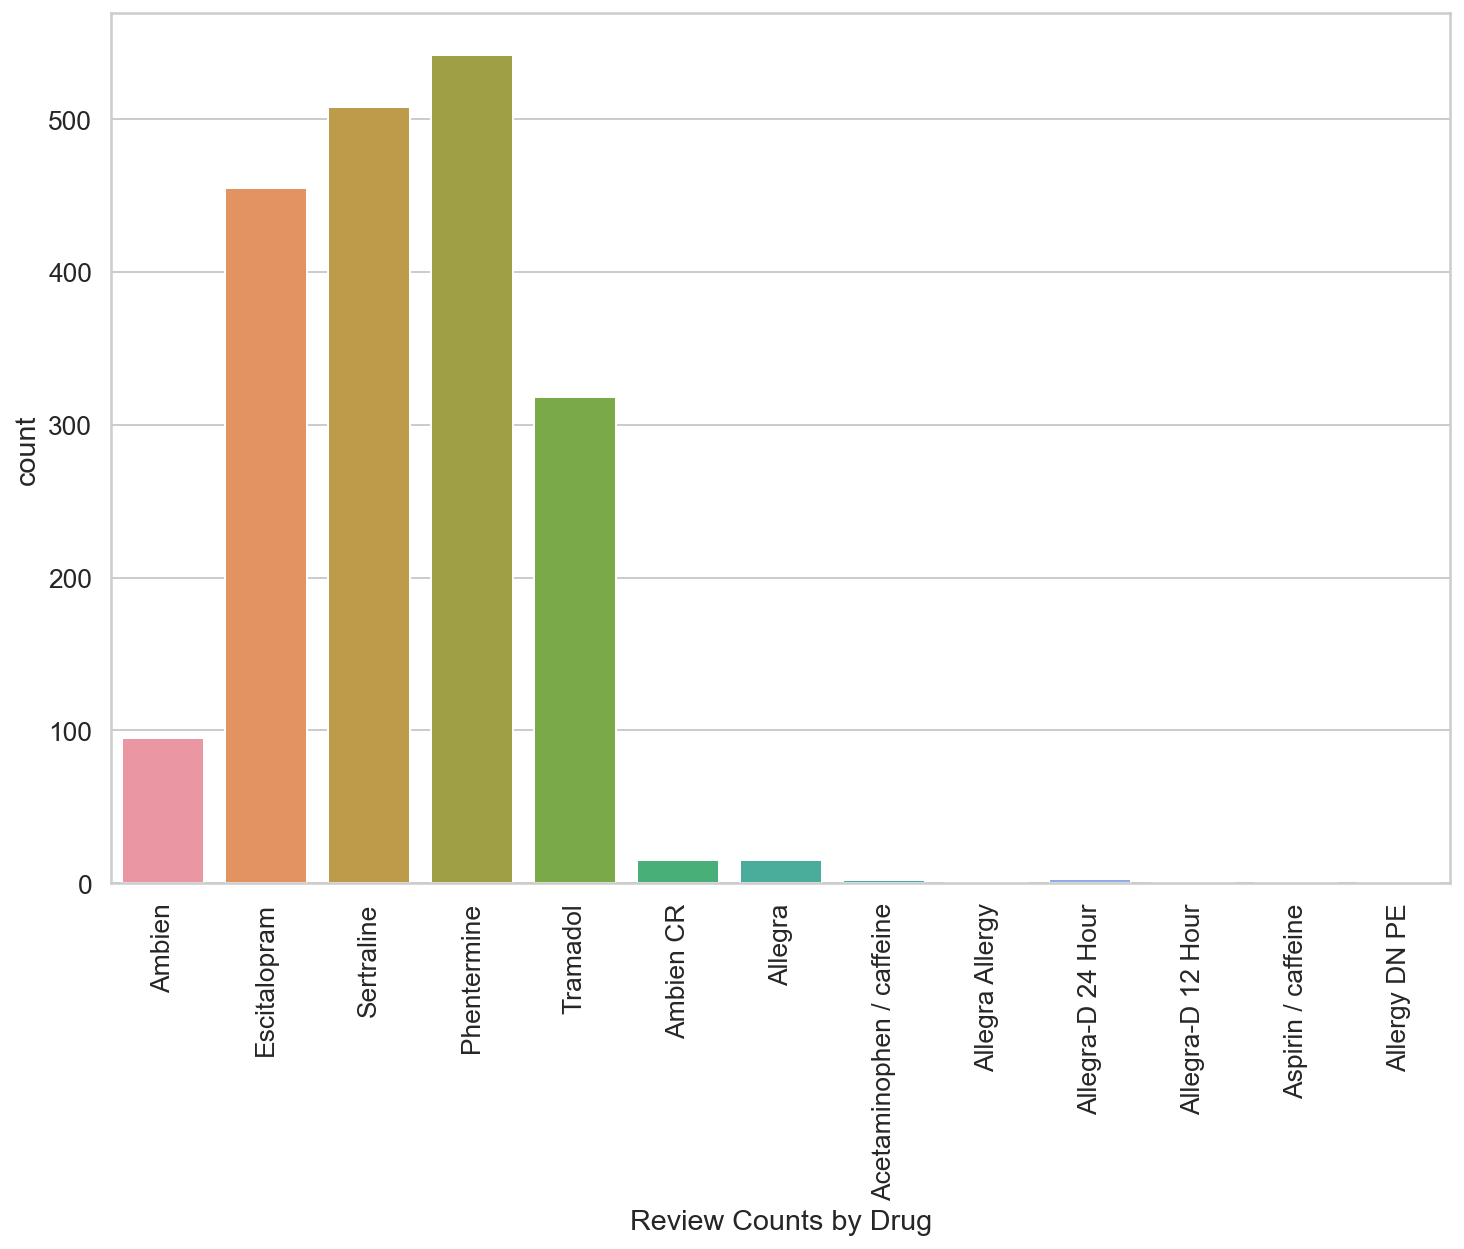

In [3]:
# Exploratory Data Analysis

df = pd.read_csv("case_study_data.txt", sep="\t", header=0)
df.head()
df.shape
df.info()
sns.countplot(df.drugName)
plt.xticks(rotation=90)
plt.xlabel('Review Counts by Drug');


We have more reviews for Phentermine than the other drugs, so we can proceed with the analysis of Phentermine reviews.

In [8]:
# Data Preprocessing with BERT
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_txt = "It's a new dawn, it's a new day, it's a new life for me. And I'm feeling good!"
# Tokenization
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

tokenizer.sep_token, tokenizer.sep_token_id # sentence ending separation
tokenizer.cls_token, tokenizer.cls_token_id # beginning sentences
tokenizer.pad_token, tokenizer.pad_token_id # padding
tokenizer.unk_token, tokenizer.unk_token_id # unknown

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=100,
  truncation=True, # explicitly truncate to max length
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length', # remove deprecated pad_to_max_length
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

# dict_keys(['input_ids', 'attention_mask']) # dict_keys doesn't work for py3
vocab = list(df.keys())
print(vocab)

# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/



 Sentence: It's a new dawn, it's a new day, it's a new life for me. And I'm feeling good!
   Tokens: ['It', "'", 's', 'a', 'new', 'dawn', ',', 'it', "'", 's', 'a', 'new', 'day', ',', 'it', "'", 's', 'a', 'new', 'life', 'for', 'me', '.', 'And', 'I', "'", 'm', 'feeling', 'good', '!']
Token IDs: [1135, 112, 188, 170, 1207, 9623, 117, 1122, 112, 188, 170, 1207, 1285, 117, 1122, 112, 188, 170, 1207, 1297, 1111, 1143, 119, 1262, 146, 112, 182, 2296, 1363, 106]
['uniqueID', 'drugName', 'review', 'date']


In [11]:
print(len(encoding['input_ids'][0])) # token ids
encoding['input_ids'][0]
print(len(encoding['attention_mask'][0])) # attention mask
encoding['attention_mask']
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) # special tokens

100
100


['[CLS]',
 'It',
 "'",
 's',
 'a',
 'new',
 'dawn',
 ',',
 'it',
 "'",
 's',
 'a',
 'new',
 'day',
 ',',
 'it',
 "'",
 's',
 'a',
 'new',
 'life',
 'for',
 'me',
 '.',
 'And',
 'I',
 "'",
 'm',
 'feeling',
 'good',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

/Users/christineamuzie/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


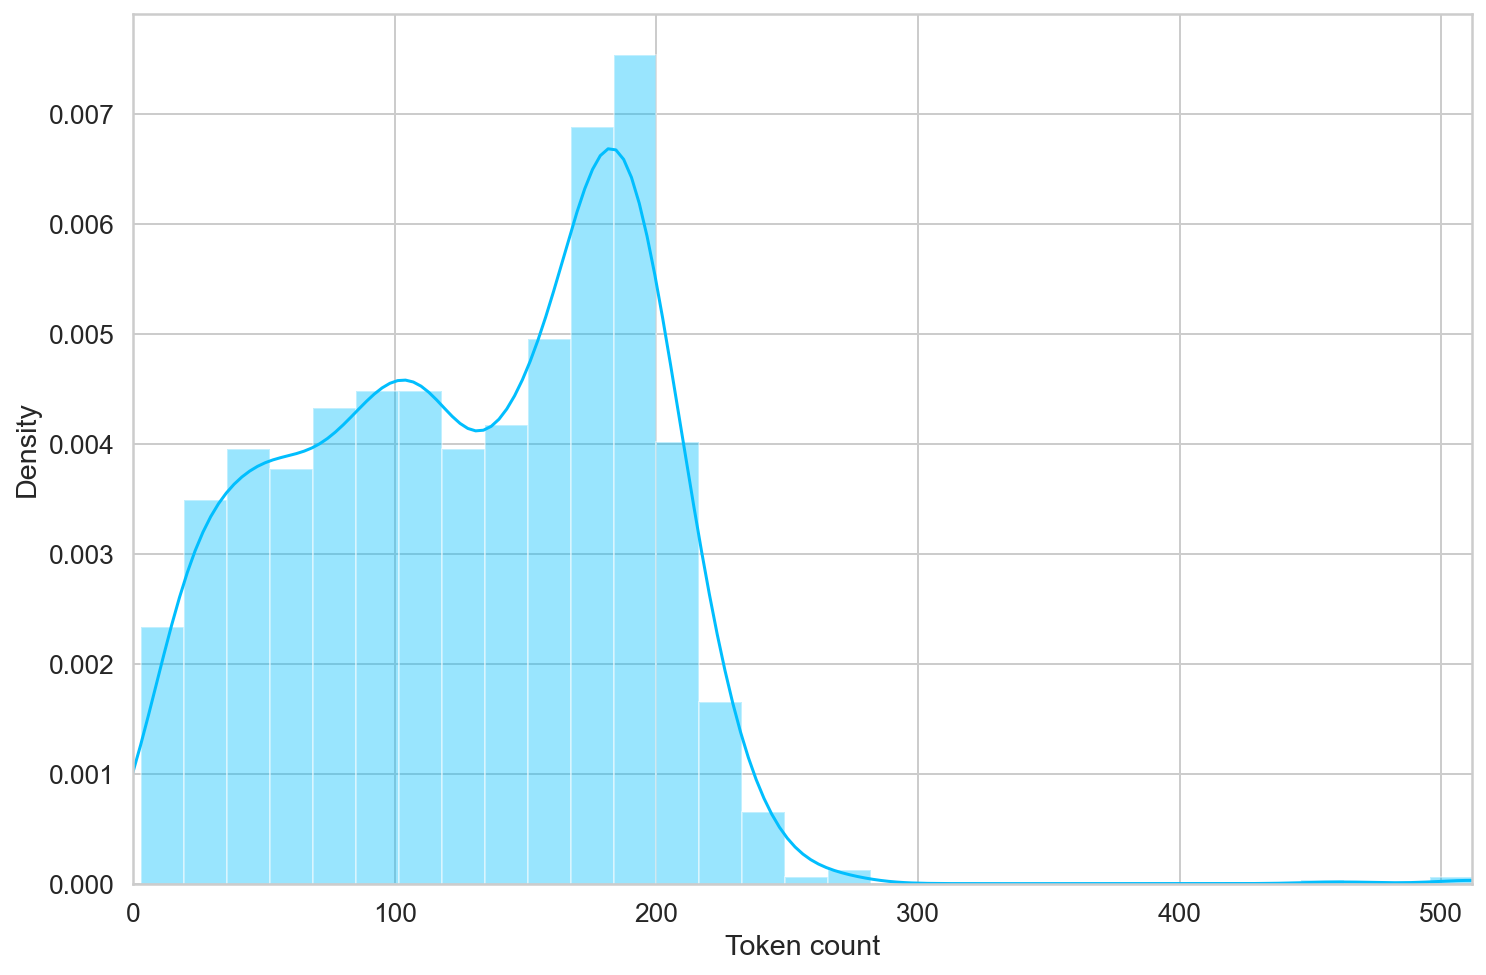

In [16]:
token_lens = [] # token length of each review
for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

sns.distplot(token_lens) # plot distribution
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 300 # majority of reviews < 300 tokens

In [5]:
# determining max length of review
import numpy as np
measurer = np.vectorize(len)
res1 = measurer(df.values.astype(str)).max(axis=0)
print(res1)

[   6   24 2642    9]


In [17]:
class RxReviewDataset(Dataset): # creating PyTorch dataset
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [19]:
df_train, df_test = train_test_split( # split data into training and test
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((1761, 4), (98, 4), (98, 4))

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size): # create data loaders
  ds = RxReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16 # set batch size
MAX_LEN = 300 # majority of reviews < 300 tokens
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

TypeError: __init__() missing 1 required positional argument: 'targets'

In [27]:
class SentimentClassifier(nn.Module): # BERT-based classifier
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [28]:
model = SentimentClassifier(len(class_names))
model = model.to(device) # move to GPU

NameError: name 'class_names' is not defined

Broader Impact Data Services, LLC &copy; 2021